# **Detection of intracranial hemorrhage (ICH) and Interpretability using Grad-CAM Visualization**


**Setup environment**

In [ ]:
!pip install Pillow==9.0.0
!pip install matplotlib==3.1.3
!python -c "import monai" ||pip install "monai[nibabel, skimage, pillow, tensorboard, gdown, ignite, torchvision, einops, itk, tqdm, lmdb, psutil]"
!pip install itkwidgets
!pip install itk-io
!pip install vit-pytorch

**Setup imports**

In [ ]:
import logging
import os
import sys
import tempfile
import shutil
import nibabel as nib
import matplotlib.pyplot as plt
import torch
from torch.utils.tensorboard import SummaryWriter
from ipywidgets import interact, interactive, IntSlider, ToggleButton
import numpy as np
import matplotlib as mpl

import monai
from monai.networks.nets import DenseNet121, Classifier, EfficientNet, EfficientNetBN
from monai.apps import download_and_extract
from monai.config import print_config
from monai.utils import first
from monai.visualize import GradCAM,GradCAMpp
from monai.metrics import ConfusionMatrixMetric, get_confusion_matrix
from monai.data import CacheDataset, DataLoader, ImageDataset, ITKReader, PILReader, Dataset, partition_dataset_classes, partition_dataset
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay, roc_auc_score, balanced_accuracy_score
from monai.visualize import blend_images, matshow3d, plot_2d_or_3d_image
from monai.data import decollate_batch
from monai.metrics import ROCAUCMetric
from torch.utils.data import DataLoader 
from monai.transforms import Transform
from monai.transforms import (
    AddChannel,
    Compose,
    LoadImage,
    RandRotate90,
    AsChannelFirstd,
    ScaleIntensityd,
    Rotate90d,
    DivisiblePadd,
    Invertd,
    RandRotate,
    RandFlip,
    RandZoom,
    Lambda,
    Resize,
    Orientation,
    GibbsNoise,
    RandBiasField,
    RandGaussianNoise,
    RandAdjustContrast,
    Orientationd,
    EnsureChannelFirstd,
    ScaleIntensity,
    AsChannelFirst,
    AsChannelLast,
    Activations,
    AddChannel,
    AddChanneld,
    ToTensord,
    Resized,
    AsDiscrete,
    Spacingd,
    EnsureChannelFirst,
    RepeatChannel,
    RemoveRepeatedChannel,
    ScaleIntensityRanged,
    SplitChannel,
    SqueezeDim,
    ToTensor,
    CropForegroundd,
    Randomizable,
    LoadImaged,
    ToTensord,
    MaskIntensityd,
    Flip,
    MaskIntensity,
    ScaleIntensityd,
    EnsureType,
    EnsureTyped,
)
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pandas as pd
import seaborn as sns 
import itk
import matplotlib
from enum import Enum
import tensorboard
from itkwidgets import view
from random import shuffle
from sklearn import metrics
import PIL

from glob import glob
import logging
from abc import ABC, abstractmethod
from typing import Any, Callable, Dict, Generator, Hashable, Iterable, List, Optional, Tuple
from monai.utils import first, set_determinism 
from monai.data.utils import partition_dataset_classes
from math import ceil
from natsort import natsorted
from tqdm.notebook import tqdm, trange
#from downloaddata import fetch_data as fdata
import matplotlib.pyplot as plt
!pip install -q itkwidgets

from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc, roc_auc_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from monai.transforms import Transform, AddChannel, AsChannelFirst
from monai.networks.utils import eval_mode, train_mode
from monai.data.utils import pad_list_data_collate
from monai.visualize import GradCAM, GradCAMpp, OcclusionSensitivity

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
print_config()

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


MONAI version: 0.8.1
Numpy version: 1.21.6
Pytorch version: 1.11.0+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 71ff399a3ea07aef667b23653620a290364095b1

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 9.0.0
Tensorboard version: 2.8.0
gdown version: 4.4.0
TorchVision version: 0.12.0+cu113
tqdm version: 4.64.0
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.3.5
einops version: 0.4.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



**Data Managment**

In [ ]:
data_dir= '/content/drive/MyDrive/Charite_Projekt_1/Slices_TBI/Data'
labels_all = pd.read_csv(r'/content/drive/MyDrive/Charite_Projekt_1/Labels_TBI_filtered.csv', delimiter=';')
labels=np.array(labels_all.Label)
orig_labels=labels
print(len(orig_labels))

images = sorted(glob(os.path.join(data_dir, "/content/drive/MyDrive/Charite_Projekt_1/Slices_TBI_filtered", "*.png")))
images=natsorted(images)
print(images)

data = [{"image": i, "label": l} for i, l in zip(images, labels)]
print(data)

Num images to be used: 187


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


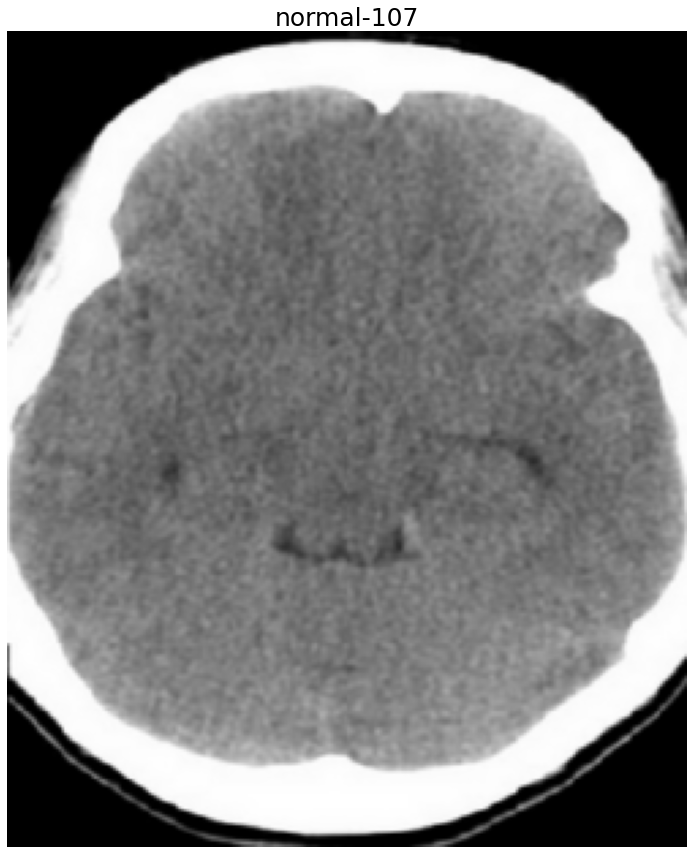

In [ ]:
class Classes(Enum):
    normal = 0
    TBI = 1

#shuffle(data)
print(f"Num images to be used: {len(data)}")

batch_size = 4
divisible_factor = 2
transforms = Compose([
    LoadImaged("image"),
    AsChannelFirstd("image"),
    ScaleIntensityd("image"),
    Resized(keys=["image"], spatial_size=(250, 300)),
    Rotate90d("image", k=3),
    DivisiblePadd("image", k=divisible_factor)
])

ds = Dataset(data, transforms)
dl = DataLoader(
    ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    collate_fn=pad_list_data_collate,
    drop_last=True,
)

def imshow(data):
    nims = len(data)
    if nims < 6:
        shape = (1, nims)
    else:
        shape = int(np.floor(np.sqrt(nims))), int(np.ceil(np.sqrt(nims)))
    fig, axes = plt.subplots(*shape, figsize=(15, 15))
    axes = np.asarray(axes) if nims == 1 else axes
    for d, ax in zip(data, axes.ravel()):
        # channel last for matplotlib
        filename=d['image_meta_dict']['filename_or_obj']
        #print(filename)
        name_short = filename.replace("/content/drive/MyDrive/Charite_Projekt_1/Slices_TBI_filtered/", "")
        name_short = name_short.replace(".png", "")
        #print(name_short)

        im = np.moveaxis(d["image"], 0, -1)
        ax.imshow(im, cmap='gray')
        ax.set_title(Classes(d['label']).name + '-' + name_short, fontsize=25)
        #ax.set_title(name_short, fontsize=25)
        ax.axis("off")
    plt.show()

# Random images
#rand_idxs = np.random.choice(len(ds), size=12, replace=False)
rand_idxs=np.array([100])
#print(rand_idxs)

imshow([ds[i] for i in rand_idxs])

**Preprocessing**

In [ ]:
set_determinism(seed=111)

transforms = Compose([
    LoadImaged("image"),
    AsChannelFirstd("image"),
    ScaleIntensityd("image"),
    Resized(keys=["image"], spatial_size=(250, 300)),
    Rotate90d("image", k=3),
    DivisiblePadd("image", k=divisible_factor)
])

data_partition= partition_dataset_classes(data, labels.tolist(), shuffle=True, ratios=[0.8, 0.2])

# create a training data loader
train_ds = CacheDataset(data=data_partition[0], transform=transforms)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=False, num_workers=4, pin_memory=torch.cuda.is_available())

# create a validation data loader
val_ds = CacheDataset(data=data_partition[1], transform=transforms)
val_loader = DataLoader(val_ds, batch_size=2, shuffle=False, num_workers=4, pin_memory=torch.cuda.is_available())

# create a test data loader
test_ds = CacheDataset(data=data_partition[1], transform=transforms)
test_loader = DataLoader(test_ds, batch_size=2, shuffle=False, num_workers=4, pin_memory=torch.cuda.is_available())

post_pred = Compose([EnsureType(), Activations(softmax=True)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=2, n_classes=2)])

Loading dataset: 100%|██████████| 149/149 [00:08<00:00, 17.96it/s]
This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
Loading dataset: 100%|██████████| 38/38 [00:01<00:00, 27.27it/s]


In [ ]:
# Modell Definition
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_determinism(111)

model = monai.networks.nets.DenseNet121(spatial_dims=2, in_channels=4, out_channels=2, pretrained=False)
#model.load_state_dict(torch.load("/content/drive/MyDrive/Charite_Projekt_1/TBI_untrained_final.pth"))
model.to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
auc_metric = ROCAUCMetric()
#print(model)

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
Computing optimal learning rate:  55%|█████▌    | 11/20 [00:13<00:11,  1.26s/it]


Stopping early, the loss has diverged
Resetting model and optimizer


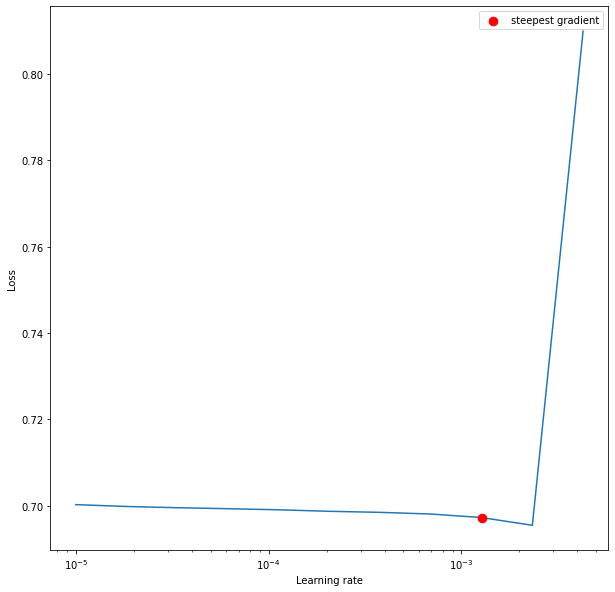

In [ ]:
%matplotlib inline
#Learning Rate Finder

lower_lr, upper_lr = 1e-5, 1e-0
optimizer = torch.optim.Adam(model.parameters(), lower_lr)
lr_finder = monai.optimizers.LearningRateFinder(model, optimizer, loss_function, device=device)
lr_finder.range_test(train_loader, val_loader, end_lr=upper_lr, num_iter=20)
steepest_lr, _ = lr_finder.get_steepest_gradient()
ax = plt.subplots(1, 1, figsize=(10, 10), facecolor="white")[1]
_ = lr_finder.plot(ax=ax)

**Training**

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), 2e-4)

# Typical PyTorch Training
val_interval = 1
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
y_pred_act= []
metric_values = []
acc_values = []
auc_values = []
accs=[]
writer = SummaryWriter()
max_epochs = 80
for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_len = len(train_ds) // train_loader.batch_size
            #print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
            writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                y_pred = torch.tensor([], dtype=torch.float32, device=device)
                y = torch.tensor([], dtype=torch.long, device=device)
                for val_data in val_loader:
                    val_images, val_labels = val_data["image"].to(device), val_data["label"].to(device)
                    y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                    y = torch.cat([y, val_labels], dim=0)

                acc_value = torch.eq(y_pred.argmax(dim=1), y)
                acc_metric = acc_value.sum().item() / len(acc_value)
                y_onehot = [post_label(i) for i in decollate_batch(y)]
                y_pred_act = [post_pred(i) for i in decollate_batch(y_pred)]
                #print(y_onehot)
                #fpr, tpr, thresholds = metrics.roc_curve(y_onehot, y_pred_act, pos_label=2)
                #print(fpr, tpr, metrics.auc(fpr, tpr))
                auc_metric(y_pred_act, y_onehot)
                #print(auc_metric)
                auc_result = auc_metric.aggregate()
                auc_metric.reset()
                del y_pred_act, y_onehot
                metric_values.append(auc_result)
                accs.append(acc_metric)

                if acc_metric > best_metric:
                    best_metric = acc_metric
                    best_metric_epoch = epoch + 1
                    best_auc= auc_result

                    torch.save(model.state_dict(), "/content/drive/MyDrive/Charite_Projekt_1/TBI_untrained_new.pth")
                    print("saved new best metric model")
                print(
                    "current epoch: {}, current accuracy: {:.4f}, current AUC: {:.4f}, best accuracy: {:.4f}, at epoch {}".format(
                        epoch + 1, acc_metric, auc_result, best_metric, best_metric_epoch
                    )
                )

                writer.add_scalar("val_accuracy", acc_metric, epoch + 1)
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/60


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


epoch 1 average loss: 0.6054
saved new best metric model
current epoch: 1, current accuracy: 0.6579, current AUC: 0.8920, best accuracy: 0.6579, at epoch 1
----------
epoch 2/60
epoch 2 average loss: 0.4957
saved new best metric model
current epoch: 2, current accuracy: 0.6842, current AUC: 0.8283, best accuracy: 0.6842, at epoch 2
----------
epoch 3/60
epoch 3 average loss: 0.4747
saved new best metric model
current epoch: 3, current accuracy: 0.7368, current AUC: 0.8366, best accuracy: 0.7368, at epoch 3
----------
epoch 4/60
epoch 4 average loss: 0.3781
current epoch: 4, current accuracy: 0.7368, current AUC: 0.7978, best accuracy: 0.7368, at epoch 3
----------
epoch 5/60
epoch 5 average loss: 0.3067
saved new best metric model
current epoch: 5, current accuracy: 0.7895, current AUC: 0.8089, best accuracy: 0.7895, at epoch 5
----------
epoch 6/60
epoch 6 average loss: 0.3131
current epoch: 6, current accuracy: 0.7105, current AUC: 0.7812, best accuracy: 0.7895, at epoch 5
----------

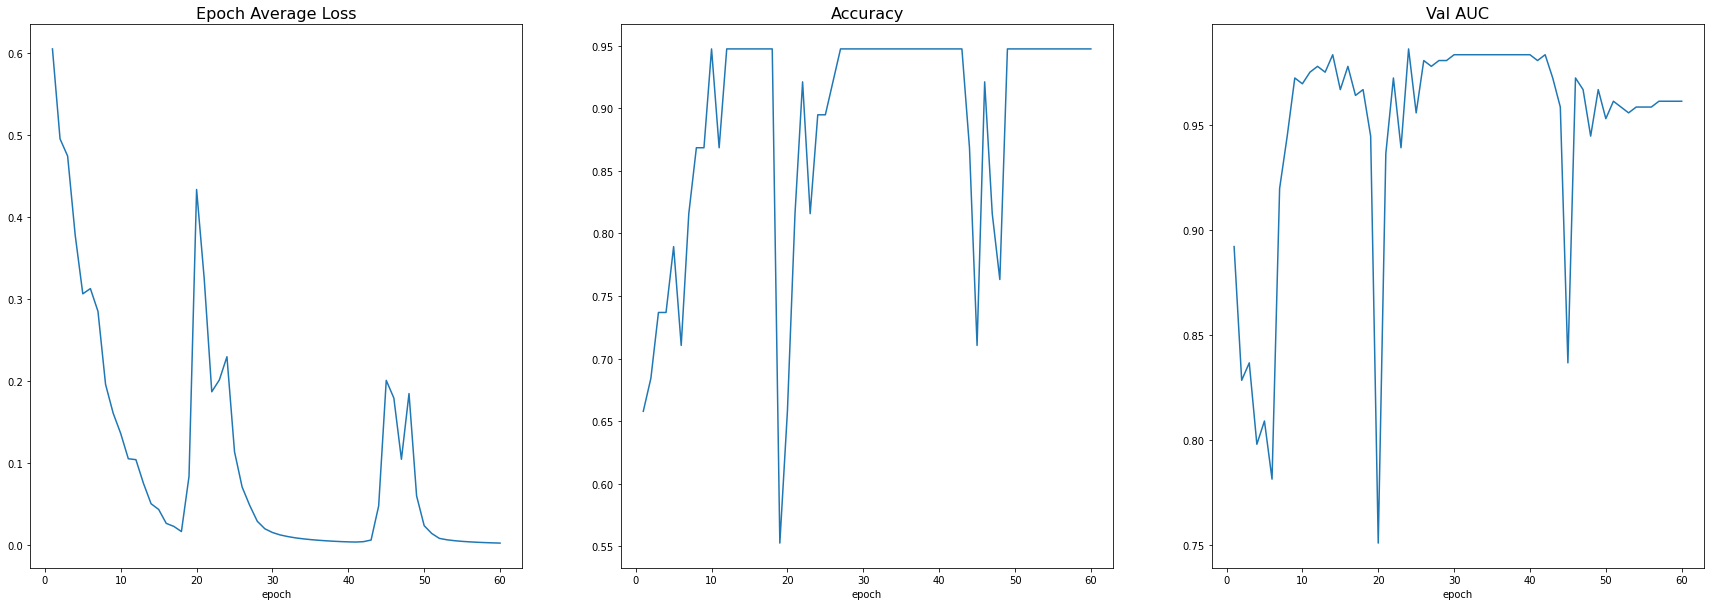

In [ ]:
plt.figure("train", (30, 10))

plt.subplot(1, 3, 1)
plt.title("Epoch Average Loss",fontsize=16)
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(1, 3, 2)
plt.title("Accuracy",fontsize=16)
x = [val_interval * (i+1) for i in range(len(accs))]
y = accs
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(1, 3, 3)
plt.title("Val AUC",fontsize=16)
x = [val_interval * (i+1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)

plt.show()

**Confusion Matrix**

  0%|          | 0/46 [00:00<?, ?it/s]

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


              precision    recall  f1-score   support

      normal       0.98      1.00      0.99        92
         TBI       1.00      0.98      0.99        92

    accuracy                           0.99       184
   macro avg       0.99      0.99      0.99       184
weighted avg       0.99      0.99      0.99       184



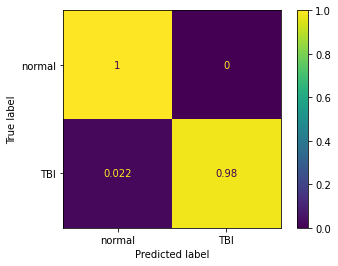

In [ ]:
def nullcontext():
  yield

with eval_mode(model):
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)

    for data in tqdm(dl):
        images, labels = data["image"].to(device), data["label"].to(device)
        with torch.cuda.amp.autocast() if True else nullcontext():
            outputs = model(images).detach()
        y_pred = torch.cat([y_pred, outputs], dim=0)

        y = torch.cat([y, labels], dim=0)
    #y= y.argmax(dim=1))
    orig_labels = np.array(y.cpu() )   

    y_pred = y_pred.argmax(dim=1)
    pred_labels=np.array(y_pred.cpu() )
    #print(pred_labels)
    #print(orig_labels)
    
    print(classification_report(
    y.cpu().numpy(),
    y_pred.cpu().numpy(),
    target_names=[d.name for d in Classes]))

    cm = confusion_matrix(
        y.cpu().numpy(),
        y_pred.cpu().numpy(),
        normalize='true',
    )
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=[a.name for a in Classes],
    )
    _ = disp.plot(ax=plt.subplots(1, 1, facecolor='white')[1])
  

In [ ]:
from sklearn import metrics
from scipy import interp

bas=balanced_accuracy_score(orig_labels,pred_labels)
print('BAS:',bas)
sensitivity= cm[0][0]
specificity= cm[1][1]
print('Sensitivität:',sensitivity)
print('Spezifität:',specificity)
print('AUCROC:', best_auc)




BAS: 0.9891304347826086
Sensitivität: 1.0
Spezifität: 0.9782608695652174
AUCROC: 0.9695290858725761


**Grad-CAM Visualization (scroll down to see the results)**

---------
ID: 21
Orig: TBI
Pred: TBI
---------
ID: 100
Orig: normal
Pred: normal


You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("autumn").copy()


---------
ID: 16
Orig: TBI
Pred: TBI
---------
ID: 126
Orig: normal
Pred: normal
---------
ID: 28
Orig: TBI
Pred: TBI
---------
ID: 14
Orig: TBI
Pred: TBI
---------
ID: 20
Orig: TBI
Pred: TBI
---------
ID: 121
Orig: normal
Pred: normal
---------
ID: 40
Orig: TBI
Pred: TBI
---------
ID: 67
Orig: TBI
Pred: TBI
---------
ID: 13
Orig: TBI
Pred: TBI
---------
ID: 65
Orig: TBI
Pred: TBI
---------
ID: 131
Orig: normal
Pred: normal
---------
ID: 181
Orig: normal
Pred: normal
---------
ID: 173
Orig: normal
Pred: normal
---------
ID: 32
Orig: TBI
Pred: TBI
---------
ID: 66
Orig: TBI
Pred: TBI
---------
ID: 118
Orig: normal
Pred: normal
---------
ID: 189
Orig: normal
Pred: normal
---------
ID: 188
Orig: normal
Pred: normal
---------
ID: 10
Orig: TBI
Pred: TBI
---------
ID: 102
Orig: normal
Pred: normal
---------
ID: 49
Orig: TBI
Pred: TBI
---------
ID: 115
Orig: normal
Pred: normal
---------
ID: 5
Orig: TBI
Pred: TBI
---------
ID: 154
Orig: normal
Pred: normal
---------
ID: 51
Orig: TBI
Pred: TBI

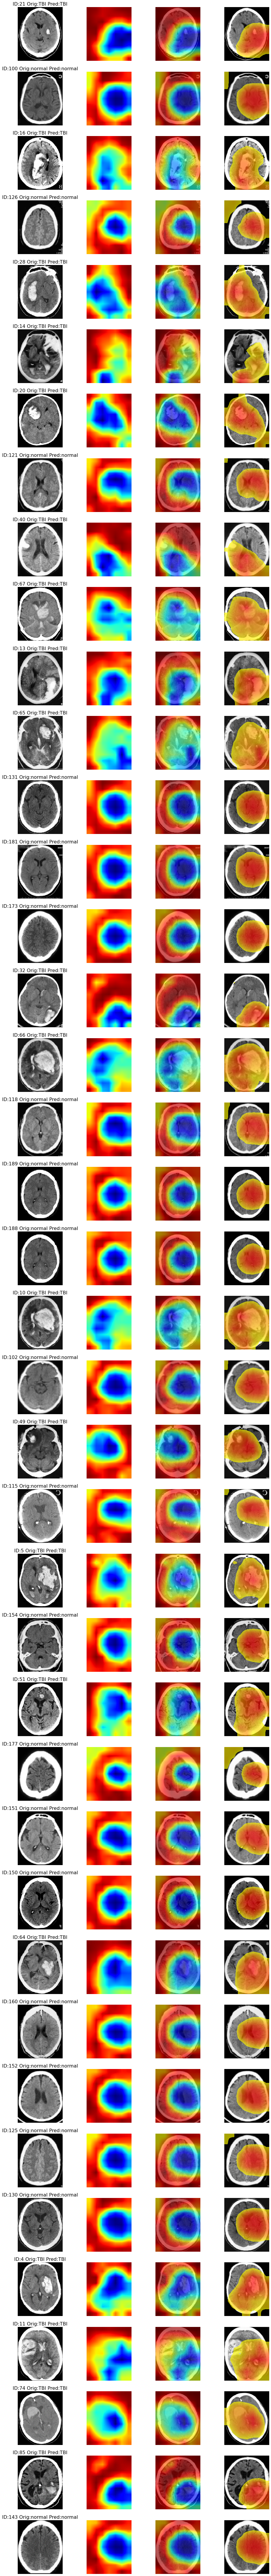

In [ ]:
# for name, _ in model.named_modules(): print(name)
target_layer = "class_layers.relu"
gradcam = GradCAM(model, target_layers=target_layer)
gradcampp = GradCAMpp(model, target_layers=target_layer)


with eval_mode(model):
    num_examples = 40
    num_cols=4
    rand_data = np.random.choice(ds, replace=False, size=num_examples)
    #rand_data=ds
    subplot_shape = [num_examples, num_cols]
    figsize = [i * 4 for i in subplot_shape][::-1]
    fig, axes = plt.subplots(*subplot_shape, figsize=figsize, facecolor='white')


    #rand_data=ds
    for row, d in enumerate(rand_data):
        img = torch.as_tensor(d["image"])[None].to(device)
        img_np=img.cpu().numpy()
        img_np=img_np[0][0]
        #print(img_np)
        minval=np.percentile(img_np,0)
        maxval=np.percentile(img_np,100)
        pixvals=np.clip(img_np,minval,maxval)
        pixvals = ((pixvals-minval) /(maxval-minval))*255
        #print(pixvals)
        #plt.imshow(img_np, cmap="gray")

        filename=d['image_meta_dict']['filename_or_obj']
        name_short = filename.replace("/content/drive/MyDrive/Charite_Projekt_1/Slices_TBI/", "")
        name_short = name_short.replace(".png", "")
      
        label = d["label"]
        orig_label=Classes(d['label']).name
        pred_label = model(img).argmax(dim=1).item()
        pred_name=Classes(pred_label).name

        print('---------')
        print('ID:',name_short)
        print('Orig:',orig_label)
        print('Pred:',pred_name)

        

        with train_mode(model):
            res_cam_pp = gradcampp(x=img, class_idx=pred_label)[0]
            

        gc_img_np=res_cam_pp
        gc_img_np=np.array(gc_img_np.cpu())
        gc_img_np=gc_img_np[0]
        #print(len(gc_img_np),len(gc_img_np[0]))
        #print(len(img_np),len(img_np[0]))
           

        for col in range(num_cols):
            ax = axes[row, col]
            #print(row,col)

            if col==0:
              ax.imshow(pixvals, interpolation='none', cmap="gray")
              ax.set_title(f"ID:"+ name_short+ " Orig:"+ orig_label+ " Pred:"+ pred_name,fontsize=16)
              #ax.set_title(f"ID:"+ name_short)
              ax.axis('off')

            if col==1:
              ax.imshow(gc_img_np,cmap='jet')

              ax.axis('off') 

            if col==2:
              ax.imshow(pixvals, cmap="gray",alpha=1)
              ax.imshow(gc_img_np, interpolation='none', cmap='jet',alpha=0.66)
              ax.axis('off') 
            
            if col==3:
              ax.imshow(pixvals, cmap="gray",alpha=1)
              cmap = mpl.cm.get_cmap("autumn")
              cmap.set_over(color='black',alpha=0.02)
              ax.imshow(gc_img_np,cmap=cmap,vmax=np.max(gc_img_np)*0.3,alpha=0.66)
              ax.axis('off')

